In [4]:
# Randomly sample files to read
import random
from pathlib import Path

in_dir = Path("data/ladys")
sample_size = 20

wav_paths = list(in_dir.rglob("*.wav"))
if sample_size < len(wav_paths):
    sampled_paths = random.sample(wav_paths, sample_size)
else:
    sampled_paths = wav_paths  

print(len(sampled_paths))

6


In [5]:
from torchaudio.functional import resample
import torch
import torchaudio
from tqdm import tqdm

hubert = torch.hub.load(
    "bshall/hubert:main",
    "hubert_discrete",
    trust_repo=True,
)

acoustic_units = {}
filenames = {}
index = 0
for wav_path in tqdm(sampled_paths, desc="Encoding Audio Features"):
    wav, sr = torchaudio.load(wav_path)
    wav = resample(wav, sr, 16000)
    wav = wav.unsqueeze(0)

    with torch.inference_mode():
        units = hubert.units(wav)
    acoustic_units[wav_path.stem] = units.numpy()
    filenames[index] = wav_path.stem
    index += 1

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Encoding Audio Features: 100%|██████████| 6/6 [00:00<00:00, 27.96it/s]


In [6]:
for path in acoustic_units:
    print(path)
    print(acoustic_units[path])
    print()

white6
[59 35 43 50 50 51 48 20 20 20 78 78]

rose5
[97 24 13 13 13  8  8  8 85 85 85 75 73 73 29 92 30 34]

lady16
[17 17 17 95 48 48 48 48 48 20 82 82 40 57 57 57 91 91 91  5 33 78 78 74
 74]

lady2
[ 6  6 90 17 17 17 17 95 48 48 48 48 48 20 20 82 82 40 40 57 57 91 91 91
  5  5 16 74 74]

lady7
[17 17 95 95 48 48 48 48 20 82 82 82 40 57 57 57 91 91 33 33 78 78 74 74]

lady0
[ 6  6 90 17 17 17 17 95 95 48 48 48 48 91 20 33 63 82 40 40 91 91 91 91
 91 91  5]



In [7]:
# KMeans
from sklearn.cluster import KMeans

def kmeans_model(url):
    model = KMeans(100)
    checkpoint = torch.hub.load_state_dict_from_url(url)

    model.__dict__["n_features_in_"] = checkpoint["n_features_in_"]
    model.__dict__["_n_threads"] = checkpoint["_n_threads"]
    model.__dict__["cluster_centers_"] = checkpoint["cluster_centers_"].numpy()
    return model


kmeans_url = "https://github.com/bshall/dusted/releases/download/v0.1/kmeans-english-50f36a.pt"
kmeans = kmeans_model(kmeans_url)

In [8]:
from segment import segment

layer = 8
gamma = 0.05

bundle = torchaudio.pipelines.WAVLM_BASE
model = bundle.get_model()
model.eval()

encodings = {}
dusted_units = {}
for wav_path in tqdm(sampled_paths, desc="Encoding Audio Features"):
    wav, sr = torchaudio.load(wav_path)
    wav = torchaudio.functional.resample(wav, sr, 16000)

    with torch.inference_mode():
        encoding, _ = model.extract_features(wav, num_layers=layer)

    encoding = encoding[layer-1].squeeze().cpu().numpy()
    encodings[wav_path.stem] = encoding

    codes, _ = segment(encoding, kmeans.cluster_centers_, gamma)   
    dusted_units[wav_path.stem] = codes

Encoding Audio Features: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


In [9]:
d_units = []
a_units = []
for path in dusted_units:
    print(path)
    print(dusted_units[path])
    d_units.append(dusted_units[path])
    print(acoustic_units[path])
    a_units.append(acoustic_units[path])
    print()
        

white6
[95 53 97 95 97]
[59 35 43 50 50 51 48 20 20 20 78 78]

rose5
[97 95 18 97]
[97 24 13 13 13  8  8  8 85 85 85 75 73 73 29 92 30 34]

lady16
[18 97 18 97 18 95 97 95]
[17 17 17 95 48 48 48 48 48 20 82 82 40 57 57 57 91 91 91  5 33 78 78 74
 74]

lady2
[95 97 95 18 95]
[ 6  6 90 17 17 17 17 95 48 48 48 48 48 20 20 82 82 40 40 57 57 91 91 91
  5  5 16 74 74]

lady7
[97 24 95 18 97 95]
[17 17 95 95 48 48 48 48 20 82 82 82 40 57 57 57 91 91 33 33 78 78 74 74]

lady0
[95 18 97 24 95 18 97 95]
[ 6  6 90 17 17 17 17 95 95 48 48 48 48 91 20 33 63 82 40 40 91 91 91 91
 91 91  5]



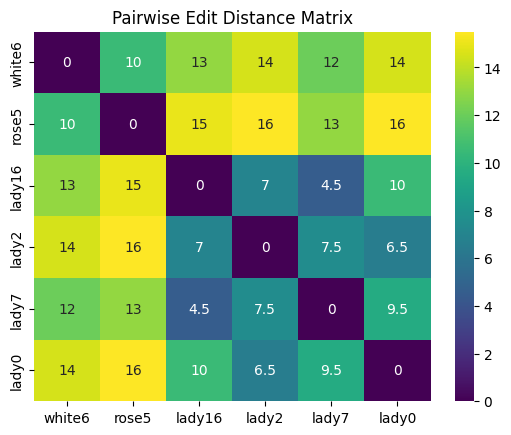

In [19]:
import numpy as np
import pandas as pd
from itertools import combinations
from nltk.metrics import edit_distance
import seaborn as sns
import matplotlib.pyplot as plt

names = list(acoustic_units.keys())
n = len(names)
dist_matrix = np.zeros((n, n))

for i, j in combinations(range(n), 2):
    name_i, name_j = names[i], names[j]
    a_i = acoustic_units[name_i]
    a_j = acoustic_units[name_j]
    d_i = dusted_units[name_i]
    d_j = dusted_units[name_j]

    dist_mat_a = edit_distance(a_i, a_j)
    dist_mat_d = edit_distance(d_i, d_j)
    
    avg_dist = (dist_mat_a + dist_mat_d)/2
    dist_matrix[i,j] = avg_dist
    dist_matrix[j,i] = avg_dist

dist_df = pd.DataFrame(dist_matrix, index=names, columns=names)

plt.Figure(figsize=(8,6))
sns.heatmap(dist_df, annot=True, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

In [8]:
import editdistance
import numpy as np

num_features = len(a_units)
dist_mat = np.zeros((num_features, num_features))

for u in range(num_features):
    for v in range(u + 1, num_features):
        dist_mat[u, v] = editdistance.eval(a_units[u], a_units[v])

print(dist_mat)

[[ 0. 10. 29. 12.  9. 26.]
 [ 0.  0. 27. 17. 17. 25.]
 [ 0.  0.  0. 24. 25. 18.]
 [ 0.  0.  0.  0.  5. 20.]
 [ 0.  0.  0.  0.  0. 21.]
 [ 0.  0.  0.  0.  0.  0.]]


In [12]:
def cluster(dist_mat, distance_threshold):
    num_nodes = dist_mat.shape[0]
    graph = {i: set() for i in range(num_nodes)}

    for i in range(num_nodes - 1): 
        for j in range(i + 1, num_nodes):  
            if dist_mat[i, j] < distance_threshold:
                graph[i].add(j)
                graph[j].add(i)  


    clusters = []
    visited = set()

    def bfs(start_node):
        """ Traverse a cluster using BFS """
        queue = [start_node]
        cluster = []
        
        while queue:
            node = queue.pop(0)
            if node in visited:
                continue 
            visited.add(node)
            cluster.append(node)
            queue.extend(graph[node])  

        return cluster

    for node in range(num_nodes):
        if node not in visited:
            new_cluster = bfs(node)
            clusters.append(new_cluster)

    return clusters

In [20]:
dist_mat += dist_mat.T

In [29]:
au_clusters = cluster(dist_mat, 15)
print(len(au_clusters))

3


In [12]:
def parse_text_to_dict(file):
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    data_dict = {}
    current_id = None
    word_dict = {}

    for line in lines: 
        line = line.strip()

        if not line: 
            continue
        
        if line.endswith(":") and not line.split(":")[0].isdigit():
            if current_id is not None:
                data_dict[current_id] = word_dict
            
            current_id = line[:-1]
            word_dict = {}
        else:
            parts = line.split(": ")
            if len(parts) == 2:
                index, word = parts
                word_dict[int(index)] = word.strip()
            else:
                parts = parts[0].split(":")
                index = parts[0]
                word_dict[int(index)] = " "
            
            if current_id is not None:
                data_dict[current_id] = word_dict
        
    return data_dict

true_words_dict = parse_text_to_dict("data/words_and_indices.txt")

In [13]:
# Cluster and WordUnit classes
from collections import defaultdict

class Cluster:
    def __init__(self,id, word_dict=None, true_words=None):
        self.id = id
        self.length = len(word_dict) if word_dict else 0
        self.word_dict = word_dict if word_dict is not None else []
        self.true_word_dict = true_words if true_words is not None else []
    
    def add_word_unit(self, id, index, file):
        word_unit = WordUnit(file, index, id)
        self.length += 1
        self.word_dict.append(word_unit)

    def add_true_word(self, word):
        self.true_word_dict.append(word)

    @classmethod
    def print_cluster(self, cluster):
        print(f"Cluster {cluster.id}")
        for word in cluster.word_dict:
            print(f"Word {word.id}: Index {word.index} in File {word.file}")
    
    def cluster_purity(self):

        word_counts = {}
        for word in self.true_word_dict:
            word_counts[word] = word_counts.get(word, 0) + 1

        max_count = max(word_counts.values()) if word_counts else 0
        cluster_purity = max_count / self.length if self.length > 0 else 0

        self.purity = cluster_purity

    @classmethod
    def duplicate_clusters(self, clusters):
        cluster_dict = defaultdict(int)

        for cluster in clusters:
            cluster_set = frozenset(cluster)  
            cluster_dict[cluster_set] += 1  

        duplicate_count = sum(1 for count in cluster_dict.values() if count > 1)

        return duplicate_count

class WordUnit:
    def __init__(self, file, index, id):
        self.index = int(index)
        self.file = file
        self.id = int(id)
        self.start_time = None
        self.end_time = None

    def add_word_boundaries(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time

In [39]:
for i, clust in enumerate(au_clusters):
    print(f"Cluster {i}")
    for w in range(len(clust)):
        if clust[w] in filenames:
            filename = filenames[clust[w]]
            print(filename)
    print()


Cluster 0
white6

Cluster 1
rose5

Cluster 2
lady16
lady2
lady7
lady0

